In [1]:
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import SimpleITK as sitk

import matplotlib.pyplot as plt
import os
from PIL import Image, ImageEnhance
import numpy as np
import zipfile
import PIL 


from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns
import pandas as pd
import csv

from scipy import signal
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import torch
import torch.nn as nn
import torchvision
import torch
from torch.utils.data import DataLoader, random_split


from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import certifi
import ssl

ssl_context = ssl.create_default_context(cafile=certifi.where())
import wandb

In [2]:
wandb.init()

wandb: Currently logged in as: backupemailforphotos7. Use `wandb login --relogin` to force relogin


In [3]:
scans_path = "Scans"
processed_scans_path = "Processed_Scans"
unzipped_scans_path = "unzipped_scans"

In [4]:
def unzip_files(directory,unzipped_scans):
    for item in os.listdir(directory):
        if item.endswith('.zip'):
            file_path = os.path.join(directory, item)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(unzipped_scans)
            print(f"Unzipped {item}")

In [5]:
unzip_files(scans_path,unzipped_scans_path)

Unzipped CQ500-CT-216.zip
Unzipped CQ500-CT-202.zip
Unzipped CQ500-CT-46.zip
Unzipped CQ500-CT-52.zip
Unzipped CQ500-CT-148.zip
Unzipped CQ500-CT-160.zip
Unzipped CQ500-CT-174.zip
Unzipped CQ500-CT-85.zip
Unzipped CQ500-CT-91.zip
Unzipped CQ500-CT-438.zip
Unzipped CQ500-CT-362.zip
Unzipped CQ500-CT-404.zip
Unzipped CQ500-CT-410.zip
Unzipped CQ500-CT-376.zip
Unzipped CQ500-CT-389.zip
Unzipped CQ500-CT-388.zip
Unzipped CQ500-CT-411.zip
Unzipped CQ500-CT-377.zip
Unzipped CQ500-CT-363.zip
Unzipped CQ500-CT-405.zip
Unzipped CQ500-CT-439.zip
Unzipped CQ500-CT-90.zip
Unzipped CQ500-CT-84.zip
Unzipped CQ500-CT-175.zip
Unzipped CQ500-CT-161.zip
Unzipped CQ500-CT-149.zip
Unzipped CQ500-CT-53.zip
Unzipped CQ500-CT-47.zip
Unzipped CQ500-CT-203.zip
Unzipped CQ500-CT-217.zip
Unzipped CQ500-CT-229.zip
Unzipped CQ500-CT-201.zip
Unzipped CQ500-CT-215.zip
Unzipped CQ500-CT-9.zip
Unzipped CQ500-CT-51.zip
Unzipped CQ500-CT-45.zip
Unzipped CQ500-CT-177.zip
Unzipped CQ500-CT-79.zip
Unzipped CQ500-CT-163.zip

KeyboardInterrupt: 

In [ ]:
def find_dicom_files(directory, dicom_files):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            find_dicom_files(item_path, dicom_files)
        elif item_path.lower().endswith('.dcm'):
            dicom_files.append(item_path)

In [ ]:
dicom_files = []
find_dicom_files(unzipped_scans_path, dicom_files)

In [ ]:
len(dicom_files)

170729

In [ ]:
process_and_plot_dicom_files(dicom_files, processed_scans_path)

Processed_Scans/CQ500CT235 CQ500CT235


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    ]),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
])

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=30),
])

In [5]:
dataset = ImageFolder(processed_scans_path,transform = train_transform)

In [6]:
train_dl = DataLoader(dataset, 35, shuffle=True)

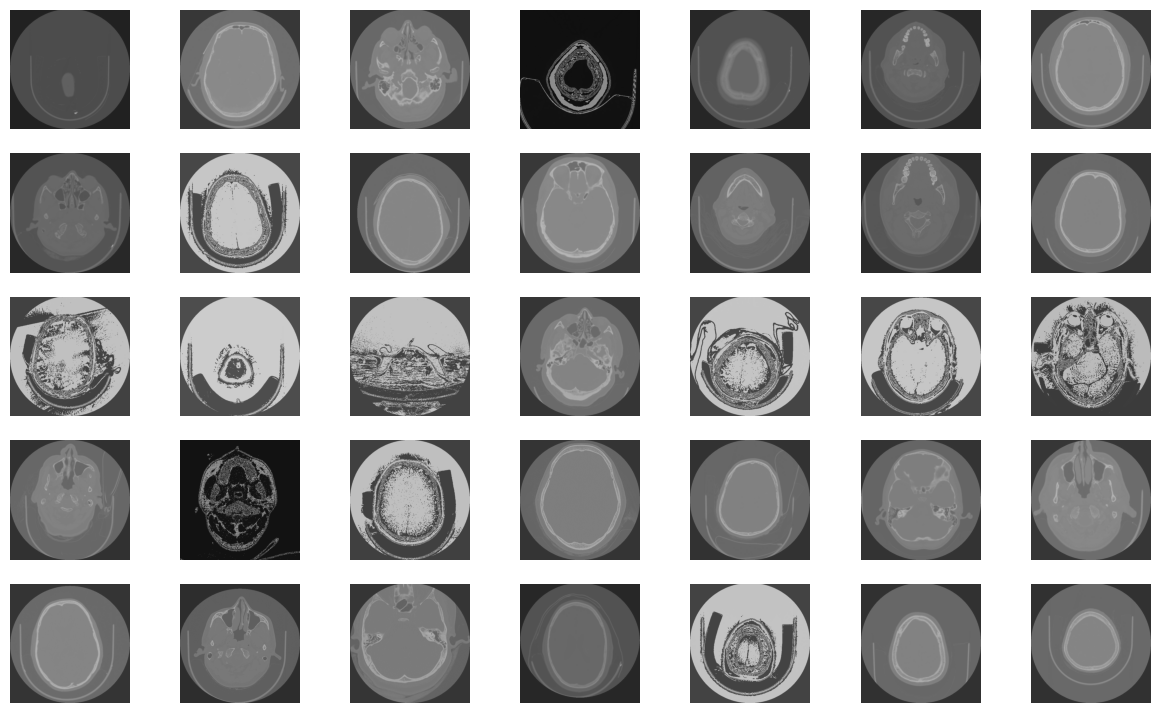

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def show_images(images):
    mean = np.array([0.5]) 
    std = np.array([0.5])
    images = images * std[:, None, None] + mean[:, None, None]
    
    # Clip pixel values to [0, 1] range
    images = np.clip(images, 0, 1)
    
    # Convert tensor to numpy array
    images = images.numpy()
    
    # Plot images
    plt.figure(figsize=(15, 9)) 
    for i in range(len(images)):
        plt.subplot(5, 7, i + 1) 
        plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap='gray')  # Assuming grayscale images
        plt.axis('off')
    plt.show()

# Load a batch of images
dataiter = iter(train_dl)
images, labels = next(dataiter)

# Show augmented images
show_images(images)


In [8]:
import re
def extract_digits(folder_name): 
    match = re.search(r'(\d+)$', folder_name) # digits at the end of folder_name
    if match:
        return int(match.group(1)) # Extracted digits converted to integer and returned
    else:
        return None # Return None if no digits are found

In [9]:
class ScanDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the scans organized in subfolders.
            csv_file (string): Path to the CSV file with labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir # directory w the scan images
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform
        self.scans = []
        self.load_scans()

    def load_scans(self):
        target_size = (512, 512)
        for subdir, dirs, files in os.walk(self.root_dir):
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                scan_id = extract_digits(folder)
                # print(f'Folder: {folder}, Scan ID: {scan_id}')
                if scan_id is not None:
                    self.labels_df['ScansNum'] = self.labels_df['ScansNum'].astype(int)
                    label_row = self.labels_df[self.labels_df['ScansNum'] == scan_id]
                    if not label_row.empty:
                        # Assuming all columns except the first are labels
                        labels = label_row.iloc[0, 1:].values  # Adjust as necessary to select the right columns
                        for file in os.listdir(folder_path):
                            if file.endswith('.png'):  # Adjust the file type as needed
                                file_path = os.path.join(folder_path, file)
                                image = Image.open(file_path)
                                if image.size == target_size:
                                    self.scans.append((file_path, labels))



    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        image_path, labels = self.scans[idx]
        image = Image.open(image_path)
        image_array = np.array(image)  # Load the image as is, without conversion to RGB
        return  torch.tensor(image_array, dtype=torch.float), torch.tensor(labels, dtype=torch.float)
    # Convert labels to a tensor if they are not already in a suitable format



In [ ]:
print("data start")
dataset = ScanDataset(root_dir= 'Processed_Scans', csv_file="weighted.csv")
print("data generated")
# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

# Perform random split
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
for images, labels in train_loader:
    # Example processing step
    print(images.shape, labels.shape)
    break
    

data start


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
model = models.resnet18(pretrained=True) # getting the pretrained weights of resnet 18

# Modify the first convolutional layer to have 1 input channel if using grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1 = model.conv1.to(device)  # Move the new conv1 layer to GPU

# Modify the fully connected output layer to match the number of classes (6 in this case)
model.fc = nn.Linear(model.fc.in_features, 6)
model.fc = model.fc.to(device)  # Move the new fc layer to GPU

# Move the entire model to the appropriate device (GPU or CPU)
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
wandb.init(project='HeyCT!')

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.unsqueeze(1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        wandb.log({"Loss": loss.item(), "Epoch": epoch+1})
        print(f'Epoch [{epoch+1}/{num_epochs}], currBatch: {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    torch.save(model.state_dict(), 'HeyCTModel1.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

In [23]:
torch.save(model.state_dict(), 'HeyCTModel1.pth')

In [24]:
# Load a model/state_dict onto GPU
model.load_state_dict(torch.load('HeyCTModel.pth', map_location='cuda'))

<All keys matched successfully>

In [25]:
# Assuming sigmoid activation needed since we are using BCEWithLogitsLoss
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for i,(images, labels) in enumerate(test_loader):
        images = images.to(device)
        images = images.unsqueeze(1)  # Ensure the input has the correct shape
        labels = labels.to(device)

        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predicted = (outputs > 0.5).float()
        # print(predicted)
        loss = criterion(outputs, labels)

        # Correct calculation for binary accuracy in multi-label setting
        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        # print(correct, total,i/len(test_loader))

accuracy = correct / total  # Calculate accuracy

print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')


Accuracy on Test Set: 88.56%


In [26]:
import torch
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix

model.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.unsqueeze(1)  # Ensure the input has the correct shape
        labels = labels.to(device)

        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predicted = (outputs >= 0.5).float()  # Threshold predictions

        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        all_labels.append(labels.cpu().numpy())  # Store true labels
        all_predictions.append(predicted.cpu().numpy())  # Store predictions

# Concatenate all batches' labels and predictions
all_labels = np.vstack(all_labels)
all_labels = np.where(all_labels >= 0.5, 1, 0)

all_predictions = np.vstack(all_predictions)

# Calculate F1 score for each label
f1_scores = f1_score(all_labels, all_predictions, average=None)  # None to calculate for each label
average_f1_score = f1_score(all_labels, all_predictions, average='macro')  # 'macro' for unweighted mean

# Calculate confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy on Test Set: {correct / total * 100:.2f}%")
print(f"F1 Scores per label: {f1_scores}")
print(f"Average F1 Score: {average_f1_score}")
print("Confusion Matrices:")
for i, matrix in enumerate(conf_matrices):
    print(f"Label {i}:")
    print(matrix)


Accuracy on Test Set: 88.56%
F1 Scores per label: [0.99401198 0.97736144 0.96611889 0.99753897 0.65126276 0.93965517]
Average F1 Score: 0.9209915335623263
Confusion Matrices:
Label 0:
[[6763    1]
 [   0   83]]
Label 1:
[[3572    1]
 [ 144 3130]]
Label 2:
[[4299    3]
 [ 164 2381]]
Label 3:
[[6236    0]
 [   3  608]]
Label 4:
[[5592    0]
 [ 649  606]]
Label 5:
[[6232    0]
 [  70  545]]


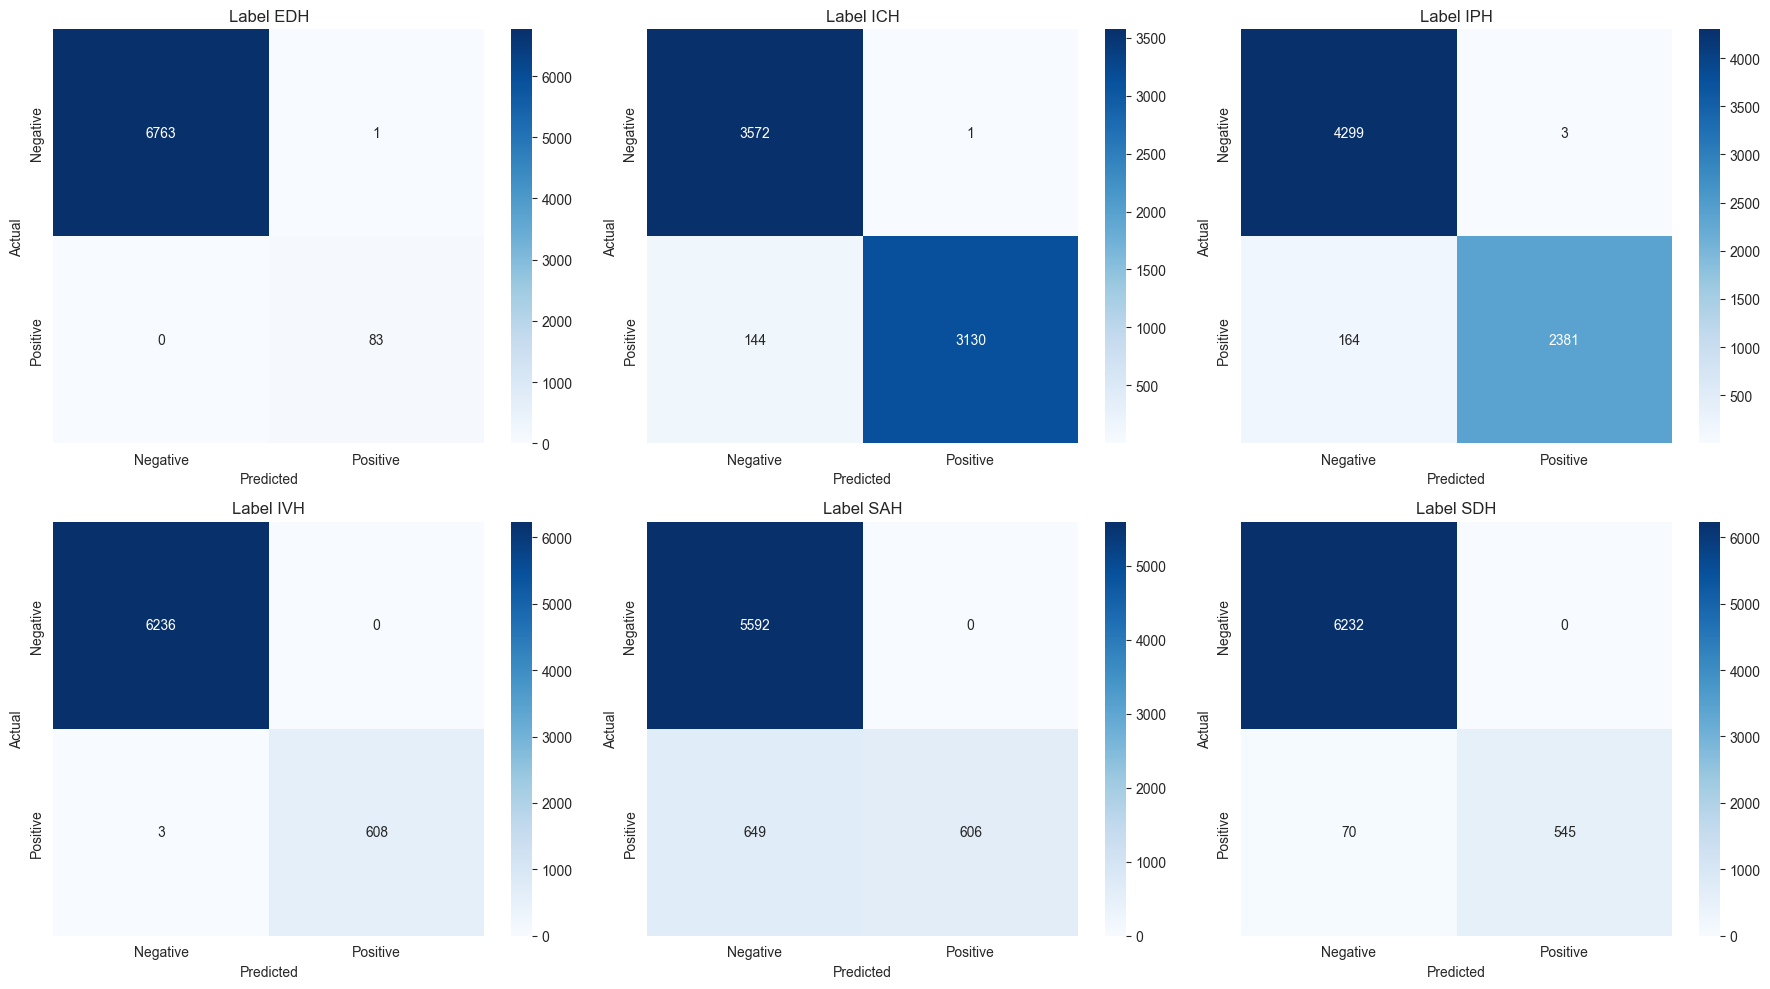

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Number of labels to plot (assumes conf_matrices is a list of matrices, one for each label)
num_labels = conf_matrices.shape[0]
injury = ['EDH','ICH','IPH','IVH',"SAH",'SDH']
for i in range(num_labels):
    plt.subplot(2, 3, i+1)  # Adjust subplot grid parameters depending on num_labels
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Label {injury[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()
